In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tvDatafeed import TvDatafeed, Interval

In [2]:
import requests
import json
import pandas as pd
import datetime

In [3]:
n=1

In [4]:
tv = TvDatafeed()
def getdata(name):
    data=tv.get_hist(symbol=name,exchange='BINANCE',interval=Interval.in_daily,n_bars=5000)
    data=data.reset_index()
#     data["datetime"]=data["datetime"]+datetime.timedelta(days=1)
    data["datetime"]=data["datetime"].dt.strftime('%Y-%m-%d')
    data2=data[data["datetime"]>="2020-01-01"].copy()
    data2["datetime"] = pd.to_datetime(data2["datetime"])
    return data2

you are using nologin method, data you access may be limited


In [5]:
def getapi(api):
    response_API=requests.get(api)
    data=response_API.text
    parse_json=json.loads(data)
    df = pd.json_normalize(parse_json['values'])
    listtime=list(df['x'])
    listtime2=[]
    for i in listtime:
        listtime2.append(datetime.datetime.fromtimestamp(i).strftime('%Y-%m-%d'))
    df['datetime']=pd.Series(listtime2)
    df["datetime"] = pd.to_datetime(df["datetime"])
#     df["datetime"]=df["datetime"]+datetime.timedelta(days=1)
    df=df[df["datetime"]>="2020-01-01"].copy()
    df=df.drop(columns=['x'])
    df.rename(columns={'y':'value'},inplace=True)
    df=df.drop_duplicates(subset=['datetime'])
    return df

In [6]:
bitcoi=getdata('BTCUSDT')
eth=getdata('ETHUSDT')
bnb=getdata('BNBUSDT')
ada=getdata('ADAUSDT')
bitcoi=bitcoi[["datetime","volume","open","high","low","close"]]
bitcoi.tail(5)

,datetime,volume,open,high,low,close
1636,2022-02-07,64872.75710,43839.99,45492.00,42666.00,44042.99
1637,2022-02-08,34428.16729,44043.00,44799.00,43117.92,44372.72
1638,2022-02-09,62351.80208,44372.71,45821.00,43174.01,43495.44
1639,2022-02-10,44971.83585,43495.44,43920.00,41938.51,42373.73
1640,2022-02-11,4492.83540,42373.73,42485.66,42156.99,42329.93


In [7]:
number_transactions=getapi('https://api.blockchain.info/charts/n-transactions?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
number_address=getapi('https://api.blockchain.info/charts/n-unique-addresses?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
transaction_second=getapi('https://api.blockchain.info/charts/transactions-per-second?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
transaction_second=transaction_second.groupby(['datetime']).mean().reset_index()
total_bitcoin=getapi('https://api.blockchain.info/charts/total-bitcoins?timespan=4years&rollingAverage=24hours&format=json&sampled=true')
volume_trade=getapi('https://api.blockchain.info/charts/trade-volume?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
hash_rate=getapi('https://api.blockchain.info/charts/hash-rate?timespan=4years&rollingAverage=24hours&format=json&sampled=false')

In [8]:
bitcoin=bitcoi.merge(eth[["datetime","close"]],on='datetime',how='left',suffixes=('_bitcoin', '_eth'))
bitcoin=bitcoin.merge(bnb[["datetime","close"]],on='datetime',how='left')
bitcoin=bitcoin.merge(ada[["datetime","close"]],on='datetime',how='left',suffixes=('_bnb', '_ada'))

In [9]:
data_api=number_transactions.merge(number_address,on='datetime',how='left',suffixes=('_number_transaction', '_number_address'))
data_api=data_api.merge(transaction_second,on='datetime',how='left')
data_api=data_api.merge(total_bitcoin,on='datetime',how='left',suffixes=('_transaction_second', '_total_bitcoin'))
data_api=data_api.merge(volume_trade,on='datetime',how='left')
data_api=data_api.merge(hash_rate,on='datetime',how='left',suffixes=('_volume_trade', '_hash_rate'))


In [10]:
bitcoin=bitcoin.merge(data_api,on='datetime',how='left')
bitcoin.tail(5)

,datetime,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate
768,2022-02-07,64872.75710,43839.99,45492.00,42666.00,44042.99,3116.69,407.8,1.176,276850.0,685310.0,2.537674,1.895052e+07,4.030174e+08,2.043262e+08
769,2022-02-08,34428.16729,44043.00,44799.00,43117.92,44372.72,3243.94,422.9,1.195,265804.0,663348.0,3.236806,1.895141e+07,3.667312e+08,1.857510e+08
770,2022-02-09,62351.80208,44372.71,45821.00,43174.01,43495.44,3072.49,414.7,1.150,260813.0,673697.0,3.135069,1.895230e+07,2.692008e+08,1.950386e+08
771,2022-02-10,44971.83585,43495.44,43920.00,41938.51,42373.73,2927.54,400.0,1.079,258595.0,664971.0,3.083160,1.895320e+07,4.642584e+08,1.884046e+08
772,2022-02-11,4492.83540,42373.73,42485.66,42156.99,42329.93,2933.09,399.9,1.076,NaN,NaN,NaN,NaN,NaN,NaN


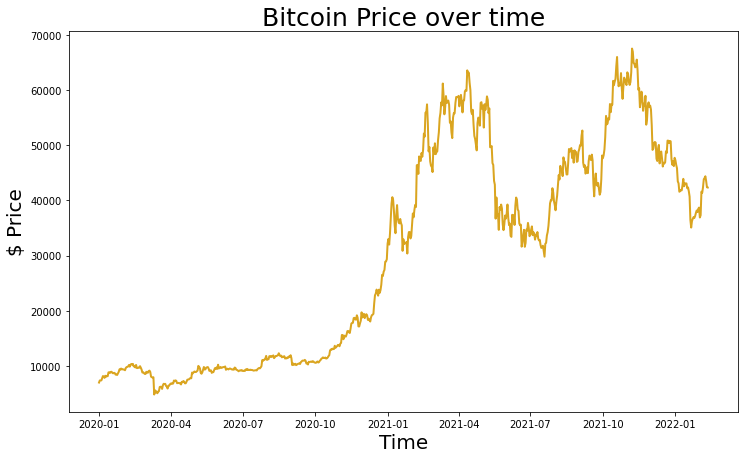

In [11]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"], bitcoin["close_bitcoin"], color='goldenrod', lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)
plt.show()

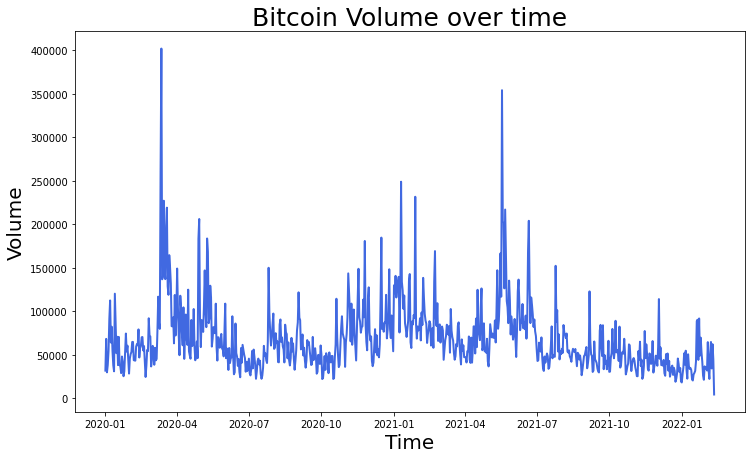

In [12]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"], bitcoin["volume"], color='royalblue', lw=2)
plt.title("Bitcoin Volume over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Volume", size=20);

In [13]:
bitcoin.isnull().sum()

datetime                     0
volume                       0
open                         0
high                         0
low                          0
close_bitcoin                0
close_eth                    0
close_bnb                    0
close_ada                    0
value_number_transaction     1
value_number_address         3
value_transaction_second     1
value_total_bitcoin         39
value_volume_trade           1
value_hash_rate              1
dtype: int64

In [14]:
# bitcoin=bitcoin.interpolate(method='linear')
temp=bitcoin["datetime"]
bitcoin=bitcoin.drop(columns=['datetime'])
bitcoin=bitcoin.interpolate()
bitcoin['datetime']=temp
bitcoin.isnull().sum()

volume                      0
open                        0
high                        0
low                         0
close_bitcoin               0
close_eth                   0
close_bnb                   0
close_ada                   0
value_number_transaction    0
value_number_address        0
value_transaction_second    0
value_total_bitcoin         0
value_volume_trade          0
value_hash_rate             0
datetime                    0
dtype: int64

In [15]:
required_features = ['volume','open', 'high', 'low','close_eth','close_bnb','close_ada','value_number_transaction','value_number_address','value_transaction_second','value_total_bitcoin','value_volume_trade', 'value_hash_rate']
output_label = 'close_bitcoin'

In [16]:
x_train, x_test, y_train, y_test = train_test_split(bitcoin[required_features],bitcoin[output_label],test_size = 0.2)

In [17]:
x_test

,volume,open,high,low,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate
424,85086.111648,45134.11,49790.00,44950.53,1569.86,254.9637,1.29627,280485.0,748049.0,3.365104,1.864101e+07,7.240613e+08,1.403886e+08
157,57952.848385,9666.85,9802.00,9372.46,244.56,17.4135,0.08657,252368.0,487527.0,3.690625,1.839598e+07,7.404058e+07,1.085396e+08
261,38440.036858,10933.40,11179.79,10887.37,385.25,27.2035,0.09141,296357.0,624125.0,3.971007,1.849302e+07,8.826939e+07,1.284789e+08
551,58210.596349,33690.15,35118.88,33532.00,2322.50,319.9200,1.41570,228279.0,579824.0,1.950694,1.874781e+07,2.626500e+08,1.013866e+08
706,38425.924660,50588.95,51200.00,48600.00,4436.91,607.2000,1.39600,266110.0,660440.0,3.423090,1.889364e+07,3.085435e+08,1.865324e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,49249.667081,51756.88,52780.00,50969.33,3926.77,496.1000,2.83300,268877.0,627019.0,2.566493,1.880650e+07,2.057639e+08,1.506115e+08
571,152452.512724,35381.02,40550.00,35205.78,2228.08,304.0000,1.25510,261950.0,644448.0,2.198090,1.876561e+07,2.136712e+08,1.019503e+08
124,76480.765342,8871.92,9118.58,8760.00,205.29,16.8886,0.04945,329075.0,652289.0,3.061632,1.835990e+07,1.866390e+08,1.262946e+08
195,39053.579665,9255.85,9276.49,9160.57,238.61,17.6351,0.13069,316064.0,671171.0,3.851215,1.843252e+07,8.824971e+07,1.189935e+08


In [18]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [19]:
model.score(x_test, y_test)

0.9990740303262224

In [20]:
future_set = bitcoin.tail(n).copy()
future_set

,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate,datetime
772,4492.8354,42373.73,42485.66,42156.99,42329.93,2933.09,399.9,1.076,258595.0,664971.0,3.08316,1.895320e+07,4.642584e+08,1.884046e+08,2022-02-11


In [21]:
prediction = model.predict(future_set[required_features])
prediction

array([42182.75077506])

In [22]:
today = datetime.date.today()
tomorrow = future_set["datetime"].iloc[0] + datetime.timedelta(days=1)
tmr = tomorrow.strftime("%B %d, %Y")
print("The prediction of bitcoin price on",tmr,"at 7 P.M. is",prediction[0])

The prediction of bitcoin price on February 12, 2022 at 7 P.M. is 42182.75077505737
